# Bibliotecas

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sn


# Importando dados

In [2]:
media_treino = pd.read_csv("data/media_treino.csv")
media_treino.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Classe
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
media_teste = pd.read_csv("data/media_teste.csv")
media_teste.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Classe
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
media_treino_sem_target = media_treino.iloc[:, 1:-1]
media_treino_sem_target.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Recriando Imagem

In [5]:
media_treino

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Classe
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
117,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
np.random.random_integers(0,10)

/tmp/ipykernel_12652/2959474533.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  np.random.random_integers(0,10)


5

In [7]:
def imagem(dataFrame):
    figure = plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    for i in range(1, 5):
        coluna = np.random.randint(0,dataFrame.shape[0])
        df_sem_target = dataFrame.iloc[:, 1:-1]
        coluna_selecionada = df_sem_target.iloc[coluna]
        imagem = coluna_selecionada.to_numpy().reshape(100, 100)
        titulo = "Boson" if dataFrame["Classe"][coluna] else "Ruido"

        figure.add_subplot(rows, cols, i)
        plt.imshow(imagem, interpolation='nearest', cmap='viridis')
        plt.title(titulo)
        plt.xlabel("$\\phi$")
        plt.ylabel("$\\eta$")
        plt.colorbar()
    plt.show()

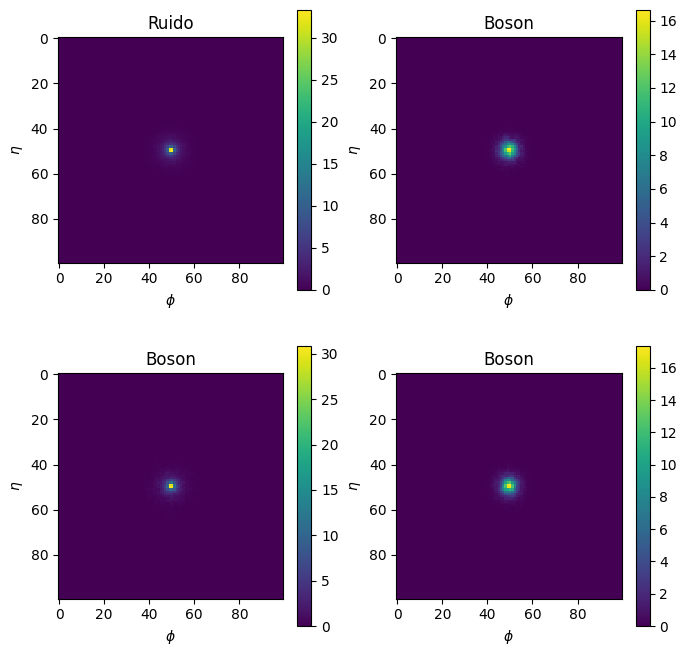

In [8]:
imagem(media_treino)

# Pre-Processamento

In [42]:
import torchvision.transforms as T


In [43]:
prep_transformation = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,),(0.5,))


    ]

)

# Criando DataLoador

In [44]:
import torch
from torch.utils.data import Dataset, DataLoader

In [45]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtendo a imagem (vetor) e o rótulo (target) da linha idx do DataFrame
        image = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)
        label = torch.tensor(self.data.iloc[idx, -1], dtype=torch.long)

        # Aplicando transformações, se necessário
        if self.transform:
            image = self.transform(image)

        return image, label


## Treino

In [46]:
train_dataset = CustomDataset(media_treino)
batch_size = 32  
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Teste

In [47]:
teste_dataset = CustomDataset(media_teste)
batch_size = 32  
teste_dataloader = DataLoader(teste_dataset, batch_size=batch_size, shuffle=True)

# Modelo

In [48]:
from torch import nn


In [49]:
class Classification(nn.Module):
  def __init__(self,entrada):
    super().__init__()


    self.layers = nn.Sequential(
        nn.Linear(entrada,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.layers(x)

class Classification(nn.Module):
  def __init__(self,entrada):
    super().__init__()


    self.layers = nn.Sequential(
        nn.Linear(entrada,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.layers(x)

In [50]:
entrada =(100*100)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
model = Classification(entrada).to(device)

In [53]:
model

Classification(
  (layers): Sequential(
    (0): Linear(in_features=10000, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# Otimizador

In [54]:
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
#lossfunction = nn.BCEWithLogitsLoss()
lossfunction = nn.BCELoss()

# Função Treino e Teste 

In [55]:
def train(modelo,dataloader,funcao_de_custo,otimizador):
  modelo.train() # esta praparado para ser treinado
  erro_acumulativo = 0.0
  for _, (data, target) in enumerate(dataloader):
    target, imgs =  target.float().to(device), data.to(device)

    pred = modelo(imgs)
    perda = funcao_de_custo(pred,target.unsqueeze(1).to(device))

    otimizador.zero_grad() # zero os gradientes acumulados
    perda.backward() #Calculo da gradiente
    otimizador.step() # anda para a direção de menos erro

    erro_acumulativo += perda.item()
  return erro_acumulativo/len(dataloader)


def test(modelo, dataloader, funcao_de_custo):
    modelo.eval()  
    total_acertos = 0
    total_exemplos = 0
    total_loss = 0.0

    with torch.no_grad():  
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.to(device)

            pred = modelo(imgs)
            loss = funcao_de_custo(pred, target.unsqueeze(1).to(device))

            # Arredonda as previsões para o valor mais próximo (0 ou 1)
            pred_labels = torch.round(pred)

            # Calcula o número de acertos
            total_acertos += (pred_labels == target.unsqueeze(1).to(device)).sum().item()
            total_exemplos += target.size(0)
            total_loss += loss.item()

    #accuracy = total_acertos / total_exemplos
    avg_loss = total_loss / len(dataloader)

    return  avg_loss

# Treinando

In [56]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16")
     

In [57]:
vezes_treinando = 500
train_losses = []
test_losses = []
for t in range(vezes_treinando):
  train_erro = train(model,train_dataloader,lossfunction,optimizer)
  train_losses.append(train_erro)
  if t %100 ==0:
    print(f"Epoca {t}; erro : {train_erro}")
  test_erro = test(model,teste_dataloader,lossfunction)
  test_losses.append(test_erro)
print(f"erro : {test_erro}")

/tmp/ipykernel_75148/167757127.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)


Epoca 0; erro : 0.6977469325065613
Epoca 100; erro : 0.2241176813840866
Epoca 200; erro : 0.19502734951674938
Epoca 300; erro : 0.18982551991939545
Epoca 400; erro : 0.1809278503060341
erro : 0.08036461472511292


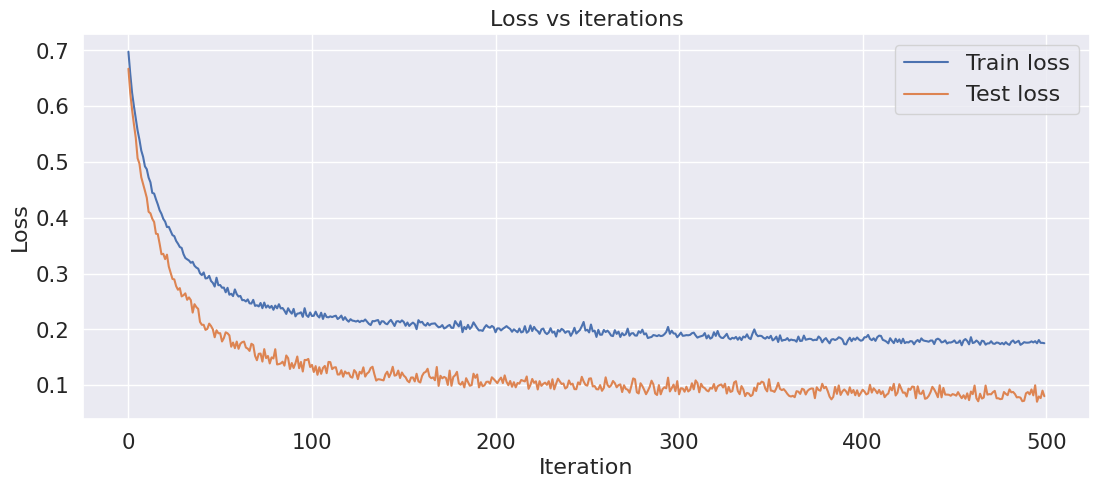

In [58]:

losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

In [59]:
# Selecionando um exemplo específico do conjunto de dados de treinamento (por exemplo, o exemplo de índice 3)
example_index = 21
example_data, _ = teste_dataset[example_index]  # Ignorando o rótulo, pois não é necessário para a inferência

# Enviando o exemplo para o dispositivo (CPU ou GPU)
example_data = example_data.to(device)

# Passando o exemplo pelo modelo para obter a saída
output = model(example_data.unsqueeze(0))  # Usando unsqueeze para adicionar uma dimensão de lote (batch)

# A saída contém as previsões do modelo para o exemplo específico
print(output)


tensor([[0.0500]], device='cuda:0', grad_fn=<SigmoidBackward0>)


/tmp/ipykernel_75148/167757127.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)


In [9]:
media_teste["Classe"][21]

0.0

# Metricas de avaliação

## Curva ROC

In [61]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(modelo, dataloader):
    modelo.eval()  # Define o modelo para o modo de avaliação
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Desliga o cálculo de gradientes para economizar memória e acelerar o processo
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.to(device)

            pred_probs = torch.sigmoid(modelo(imgs)).cpu().numpy()  # Probabilidades previstas pelo modelo
            all_probs.extend(pred_probs)
            all_labels.extend(target.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



### Teste

/tmp/ipykernel_75148/167757127.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)


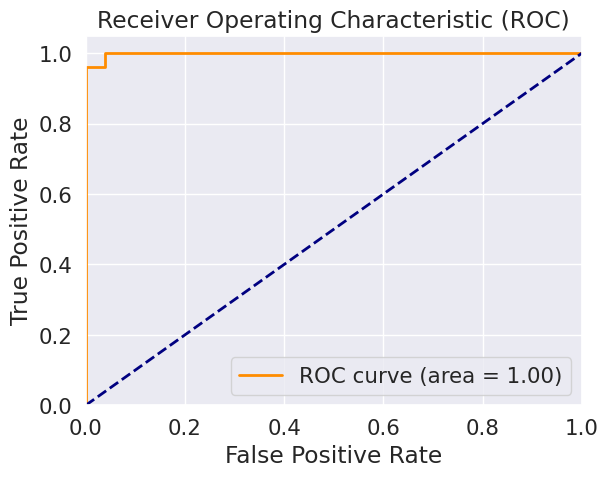

In [67]:
plot_roc_curve(model, teste_dataloader)

### Treino

/tmp/ipykernel_75148/167757127.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)


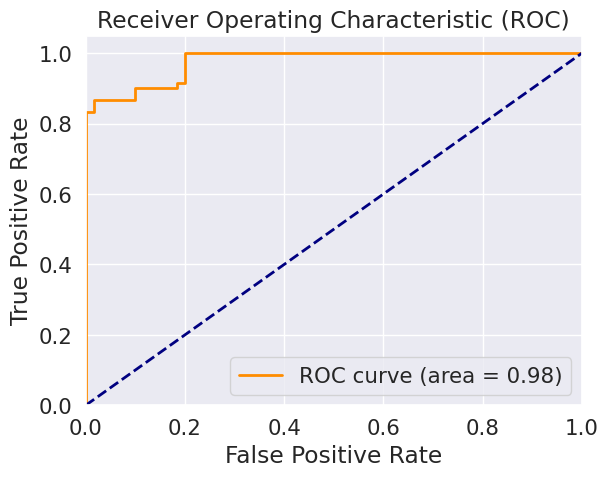

In [63]:
plot_roc_curve(model, train_dataloader)

## Matriz Confusão

In [64]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [65]:
classes = ["1","0"]
confusion_matrix = evaluate_accuracy(model, teste_dataloader, classes)


/tmp/ipykernel_75148/167757127.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)


Accuracy for class 1     is: 100.0 %
Accuracy for class 0     is: 0.0 %
Global acccuracy is 50.0


<Axes: >

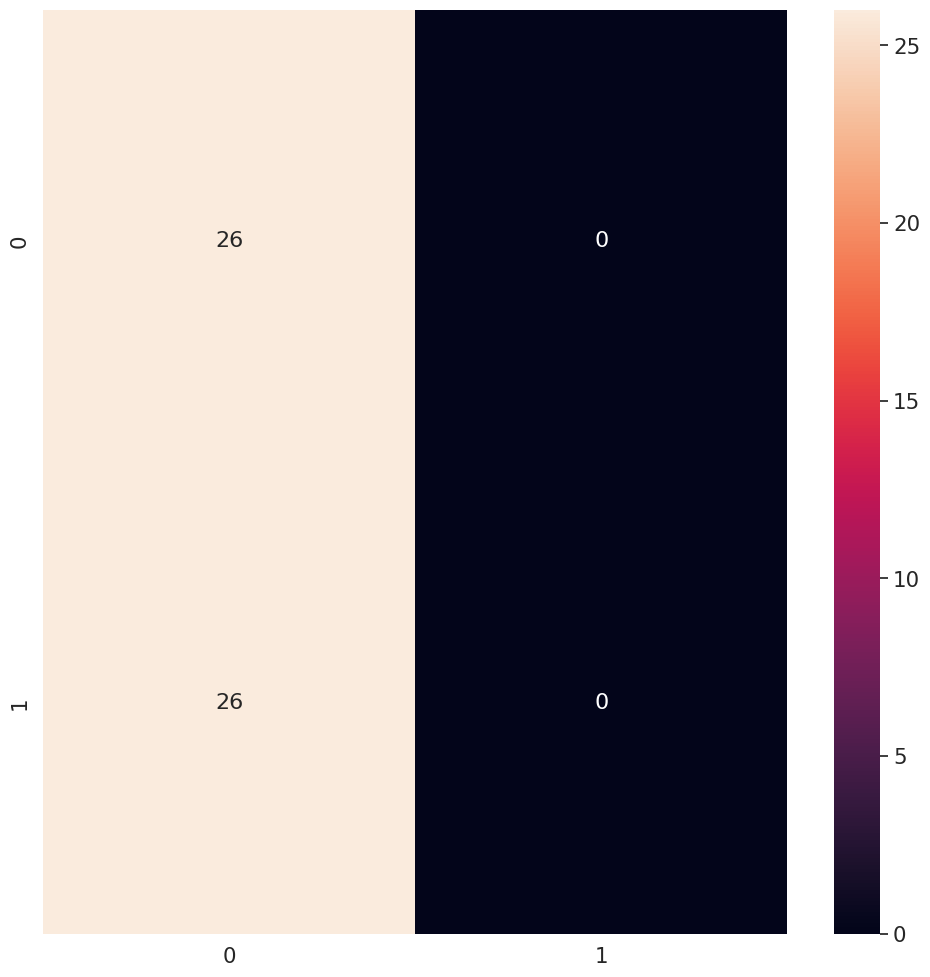

In [66]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')